### traj_3120-3150_0006554589-49NZ200107_1

** packages **

In [1]:
from ctd2xray import cchdo
from mpl_toolkits.basemap import Basemap
from pymongo import MongoClient
import gsw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from Circles.circles import circle

In [2]:
%matplotlib inline

** traj_3120-3150_0006554589 **

May 1, 1993 - May 31, 1993

In [3]:
rcs_eddies = MongoClient().eddies.rcs_eddies

In [4]:
eddy_code = 'traj_3120-3150_0006554589'

In [5]:
eddy_rclv = rcs_eddies.find_one({'_id': eddy_code})

In [6]:
eddy_traj = eddy_rclv['features'][2]['geometry']['coordinates']

In [7]:
obs_num = len(eddy_traj)

In [8]:
lon_eddy = np.zeros(obs_num)
lat_eddy = np.zeros(obs_num)

In [9]:
for i in range(obs_num):
    lon_eddy[i] = eddy_traj[i][0]
    lat_eddy[i] = eddy_traj[i][1]

** 49NZ200107_1 **

Jul. 23, 2001 - Aug. 27, 2001

In [10]:
cchdo_ctd = MongoClient().eddies.cchdo_ctd

In [11]:
expo_code = '49NZ200107_1'

In [12]:
cas_num = cchdo_ctd.find({'expocode': expo_code}).count()

In [13]:
lon_expo = np.zeros(cas_num)
lat_expo = np.zeros(cas_num)

In [14]:
# longitude range setting
# from 0 to 360
def format(longitude):
    if longitude > 0:
        longitude = longitude
    else:
        longitude = longitude + 360
    return longitude

In [15]:
i = 0
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    lon_expo[i] = format(expo['location']['coordinates'][0])
    lat_expo[i] = expo['location']['coordinates'][1]
    i = i+1

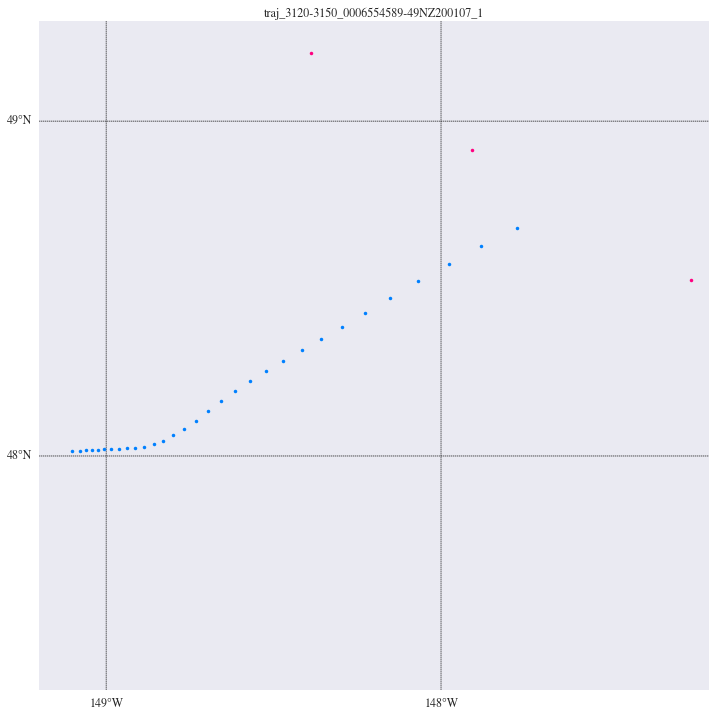

In [16]:
sns.set(color_codes=True)
plt.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['font.family'] = "STIX"
my_map = Basemap(projection='cyl', llcrnrlat=47.3, urcrnrlat=49.3,\
                 llcrnrlon=210.8, urcrnrlon=212.8, resolution='c')
my_map.fillcontinents()
parallels = np.arange(-90, 90, 1)
my_map.drawparallels(parallels, labels=[True,False,False,True])
meridians = np.arange(0, 360, 1)
my_map.drawmeridians(meridians, labels=[True,False,False,True])
x_eddy, y_eddy = my_map(lon_eddy, lat_eddy)
x_expo, y_expo = my_map(lon_expo, lat_expo)
my_map.plot(x_eddy, y_eddy, '.', color='#0080ff')
my_map.plot(x_expo, y_expo, '.', color='#ff0080')
plt.title(eddy_code + '-' + expo_code)
plt.savefig('figures/figure-1/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

** temperature-salinity **

In [17]:
STA = 70
CAS = 1

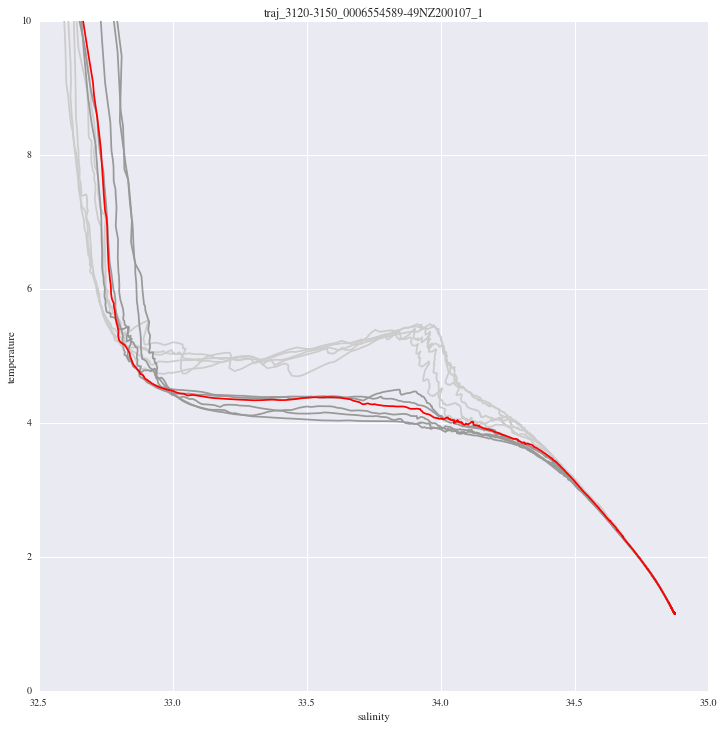

In [18]:
sns.set(color_codes=True)
mpl.rcParams['font.family'] = "STIX"
mpl.rcParams['figure.figsize'] = (12, 12)
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    ds = xr.open_dataset(expo['path'])
    woce = str(ds.WOCE_ID)
    time = ds.time.values[0]
    lon = ds.longitude.values[0]
    lat = ds.latitude.values[0]
    p = ds.pressure.values
    t = ds.temperature.values
    s = ds.salinity.values
    o = ds.oxygen.values
    sa = gsw.SA_from_SP(s, p, lon, lat)
    ct = gsw.CT_from_t(sa, t, p)
    station = int(filter(str.isdigit, str(ds.STATION_NUMBER)))
    cast = int(filter(str.isdigit, str(ds.CAST_NUMBER)))
    if (woce == 'P17N' and station == STA and cast == CAS):
        DAT = time
        LAT = lat
        plt.plot(sa, ct, color='#ff0000', zorder=2)
    elif (STA-6) < station < STA:
        plt.plot(sa, ct, color='#cccccc', zorder=1)
    elif STA < station < (STA+6):
        plt.plot(sa, ct, color='#999999', zorder=1)
plt.xlim([32.5, 35])
plt.ylim([0, 10])
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('salinity')
plt.ylabel('temperature')
plt.savefig('figures/figure-2/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

** pressure-temperature **

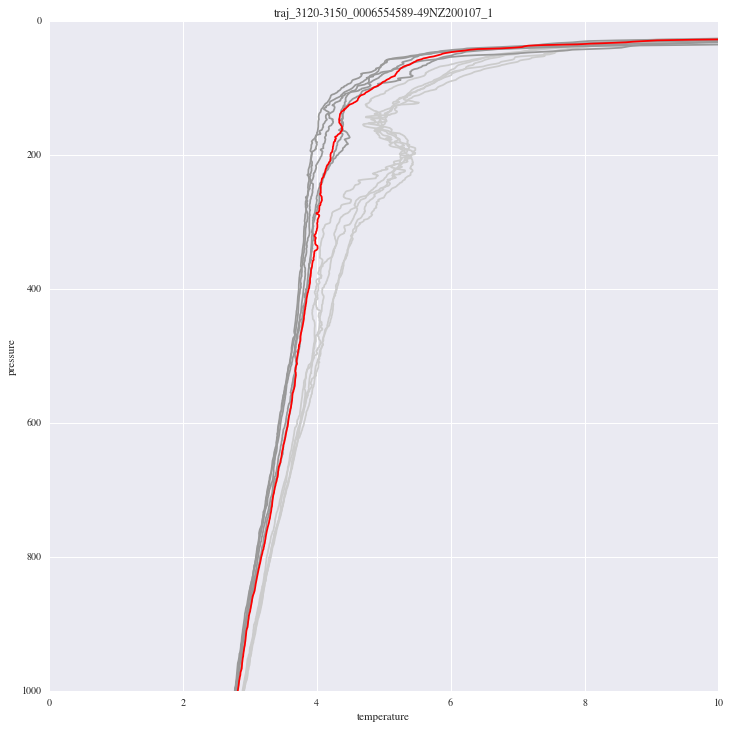

In [19]:
sns.set(color_codes=True)
plt.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['font.family'] = "STIX"
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    ds = xr.open_dataset(expo['path'])
    woce = str(ds.WOCE_ID)
    time = ds.time.values[0]
    lon = ds.longitude.values[0]
    lat = ds.latitude.values[0]
    p = ds.pressure.values
    t = ds.temperature.values
    s = ds.salinity.values
    o = ds.oxygen.values
    sa = gsw.SA_from_SP(s, p, lon, lat)
    ct = gsw.CT_from_t(sa, t, p)
    station = int(filter(str.isdigit, str(ds.STATION_NUMBER)))
    cast = int(filter(str.isdigit, str(ds.CAST_NUMBER)))
    if (woce == 'P17N' and station == STA and cast == CAS):
        LAT = lat
        plt.plot(ct, p, color='#ff0000', zorder=2)
    elif (STA-6) < station < STA:
        plt.plot(ct, p, color='#cccccc', zorder=1)
    elif STA < station < (STA+6):
        plt.plot(ct, p, color='#999999', zorder=1)
plt.xlim([0, 10])
plt.ylim([1000, 0])
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('temperature')
plt.ylabel('pressure')
plt.savefig('figures/figure-3/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

** pressure-salinity **

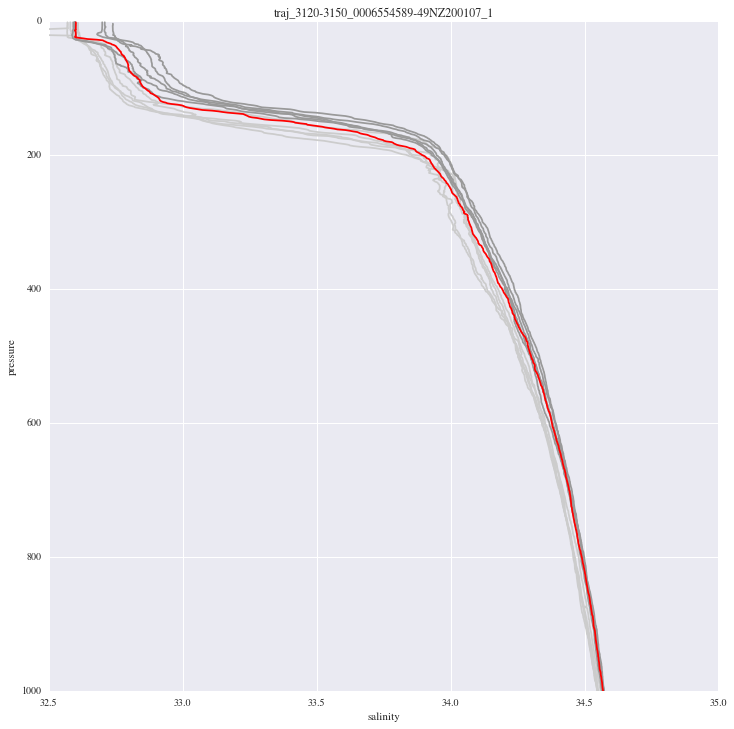

In [20]:
sns.set(color_codes=True)
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['font.family'] = "STIX"
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    ds = xr.open_dataset(expo['path'])
    time = ds.time.values[0]
    woce = str(ds.WOCE_ID)
    lon = ds.longitude.values[0]
    lat = ds.latitude.values[0]
    p = ds.pressure.values
    t = ds.temperature.values
    s = ds.salinity.values
    o = ds.oxygen.values
    sa = gsw.SA_from_SP(s, p, lon, lat)
    ct = gsw.CT_from_t(sa, t, p)
    station = int(filter(str.isdigit, str(ds.STATION_NUMBER)))
    cast = int(filter(str.isdigit, str(ds.CAST_NUMBER)))
    if (woce == 'P17N' and station == STA and cast == CAS):
        DAT = time
        LAT = lat
        plt.plot(sa, p, color='#ff0000', zorder=2)
    elif (STA-6) < station < STA:
        plt.plot(sa, p, color='#cccccc', zorder=1)
    elif STA < station < (STA+6):
        plt.plot(sa, p, color='#999999', zorder=1)
plt.xlim([32.5, 35])
plt.ylim([1000, 0])
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('salinity')
plt.ylabel('pressure')
plt.savefig('figures/figure-4/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

** pressure-oxygen **

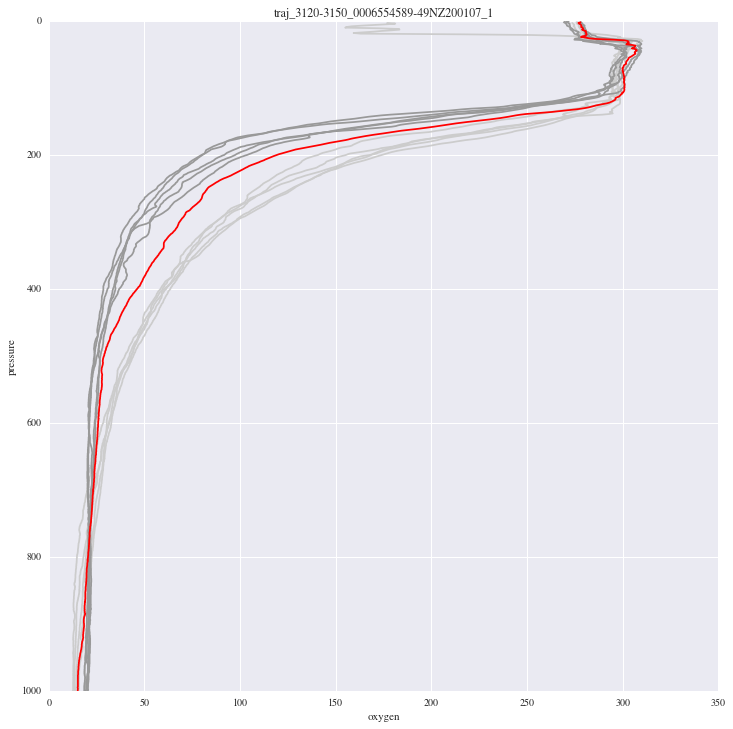

In [21]:
sns.set(color_codes=True)
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['font.family'] = "STIX"
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    ds = xr.open_dataset(expo['path'])
    woce = str(ds.WOCE_ID)
    time = ds.time.values[0]
    lon = ds.longitude.values[0]
    lat = ds.latitude.values[0]
    p = ds.pressure.values
    t = ds.temperature.values
    s = ds.salinity.values
    o = ds.oxygen.values
    sa = gsw.SA_from_SP(s, p, lon, lat)
    ct = gsw.CT_from_t(sa, t, p)
    station = int(filter(str.isdigit, str(ds.STATION_NUMBER)))
    cast = int(filter(str.isdigit, str(ds.CAST_NUMBER)))
    if (woce == 'P17N' and station == STA and cast == CAS):
        LAT = lat
        plt.plot(o, p, color='#ff0000', zorder=2)
    elif (STA-6) < station < STA:
        plt.plot(o, p, color='#cccccc', zorder=1)
    elif STA < station < (STA+6):
        plt.plot(o, p, color='#999999', zorder=1)
plt.xlim([0, 350])
plt.ylim([1000, 0])
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('oxygen')
plt.ylabel('pressure')
plt.savefig('figures/figure-5/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

** contours **

In [22]:
path_list = '/home/cz2397/data/cchdo-ctd/225_p17n_2001a_nc_ctd/p17n_2001a_000*'

In [23]:
pressure = np.linspace(0, 6000, num=6001, endpoint=True)

In [24]:
ds_tim = cchdo.open_cchdo_as_mfdataset(path_list, pressure)

In [25]:
ds_lat = ds_tim.swap_dims({'time': 'latitude'})

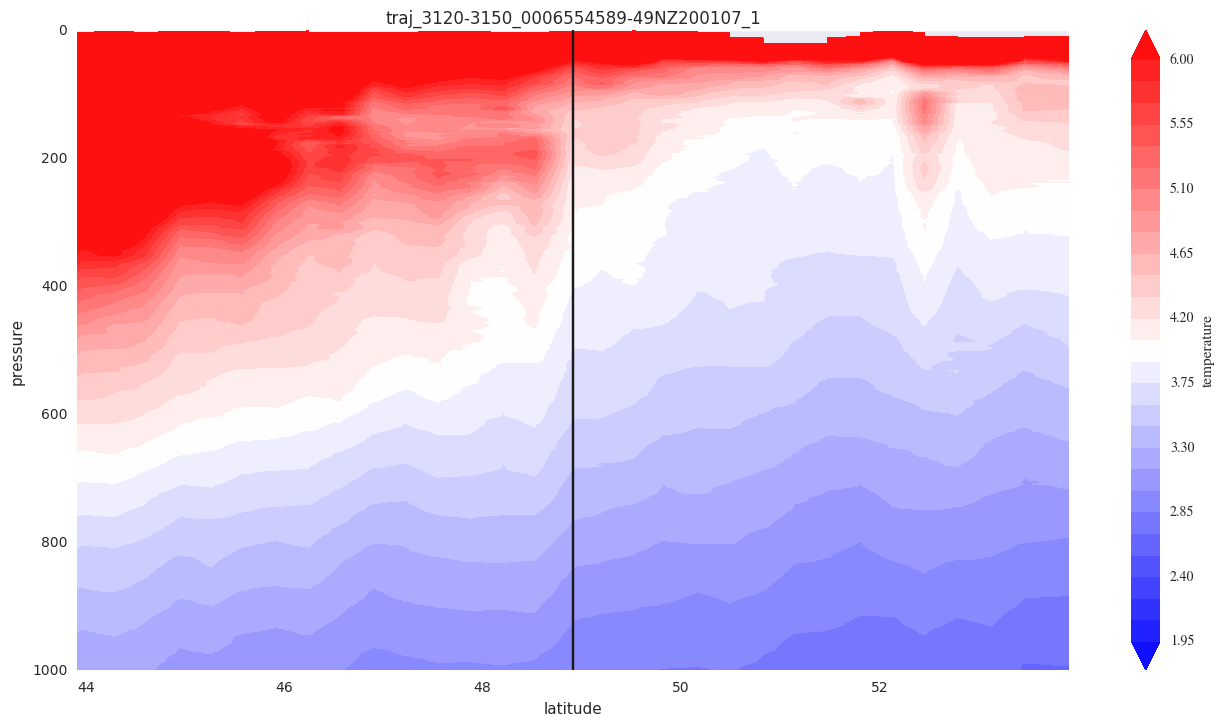

In [29]:
sns.set(color_codes=True)
fig, ax = plt.subplots(figsize=(16, 8))
mpl.rcParams['font.family'] = "STIX"
image = ds_lat.temperature_i.T.plot.contourf(yincrease=False, ax=ax, cmap='bwr',\
                                             vmin=2, vmax=6, levels=40)
image.colorbar.set_label('temperature')
plt.xlim([LAT-5, LAT+5])
plt.ylim([1000, 0])
plt.axvline(LAT, color='k')
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('latitude')
plt.ylabel('pressure')
plt.savefig('figures/figure-6/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

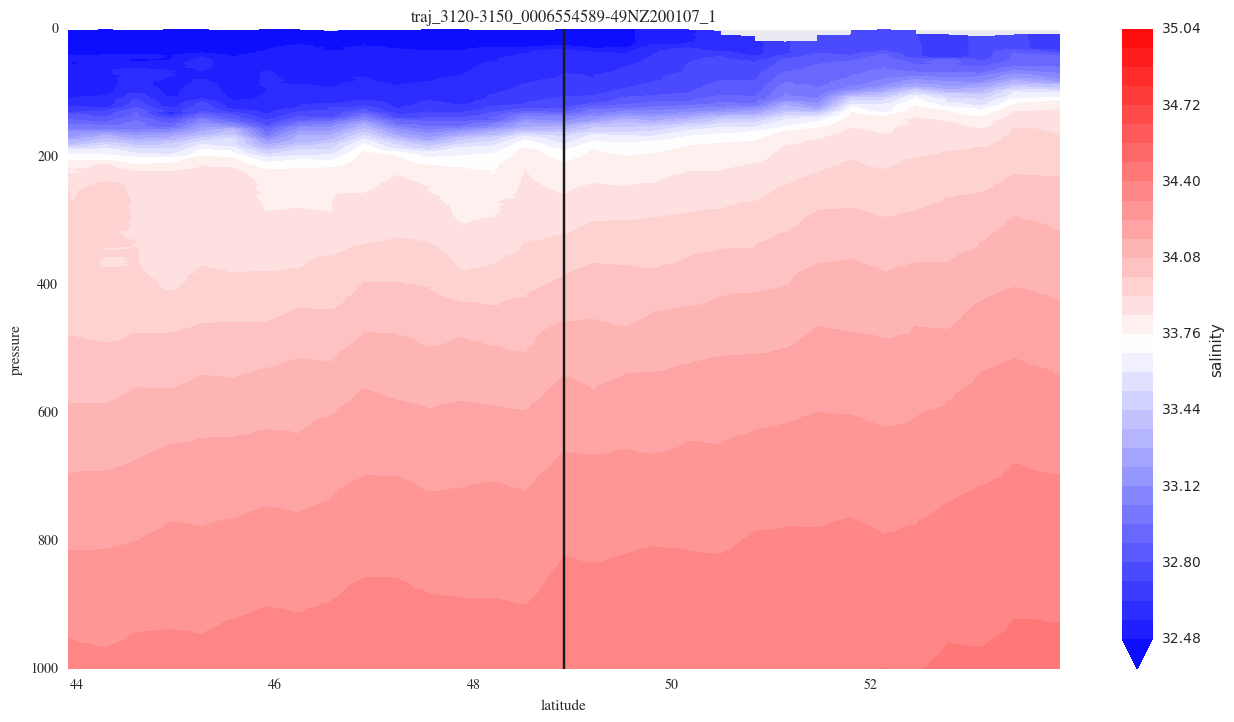

In [33]:
mpl.rcParams['font.family'] = 'STIX'
fig, ax = plt.subplots(figsize=(16, 8))
sns.set(color_codes=True)
image = ds_lat.salinity_i.T.plot.contourf(yincrease=False, ax=ax, cmap='bwr',\
                                          vmin=32.5, vmax=35, levels=40)
image.colorbar.set_label('salinity')
plt.xlim([LAT-5, LAT+5])
plt.ylim([1000, 0])
plt.axvline(LAT, color='k')
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('latitude')
plt.ylabel('pressure')
plt.savefig('figures/figure-7/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

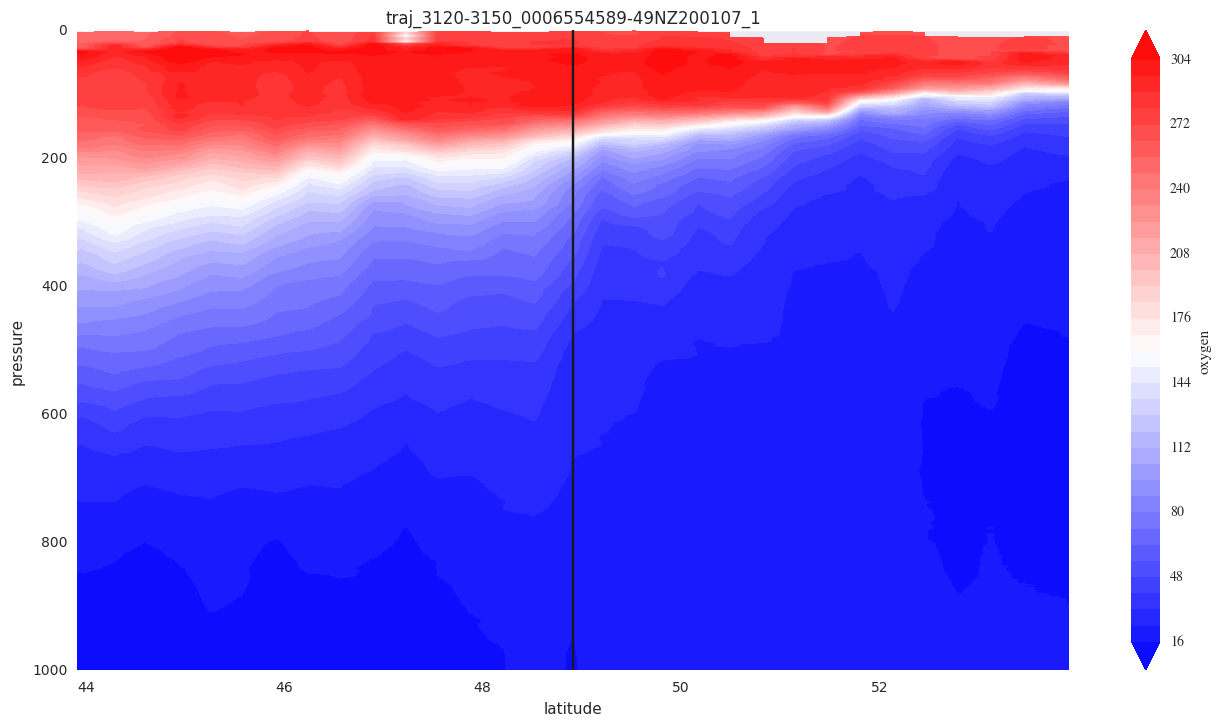

In [28]:
sns.set(color_codes=True)
fig, ax = plt.subplots(figsize=(16, 8))
mpl.rcParams['font.family'] = "STIX"
image = ds_lat.oxygen_i.T.plot.contourf(yincrease=False, ax=ax, cmap='bwr',\
                                        vmin=20, vmax=300, levels=45)
image.colorbar.set_label('oxygen')
plt.xlim([LAT-5, LAT+5])
plt.ylim([1000, 0])
plt.axvline(LAT, color='k')
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('latitude')
plt.ylabel('pressure')
plt.savefig('figures/figure-8/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()